# Ground-state energies through ionic-relaxation path from pretrained m3gnet model

In [1]:
import numpy             as np
import ML_library        as MLL
import matplotlib.pyplot as plt
import matgl
import os
import warnings
import json

from __future__                import annotations
from matgl.ext.ase             import M3GNetCalculator
from pymatgen.io.ase           import AseAtomsAdaptor

# To suppress warnings for clearer output
warnings.simplefilter('ignore')

In [2]:
model_save_path = 'finetuned_model'

# Define paths to pretrained model and structure to be relaxed
# Materials Project pretrained model as default
model_load_path = 'finetuned_model'
#model_load_path = None
model_load_path = 'M3GNet-MP-2021.2.8-PES' if model_load_path is None else model_load_path

dpi = 100

# Load the data from the JSON file
with open(f'{model_save_path}/model_parameters.json', 'r') as json_file:
    model_parameters = json.load(json_file)

# Load simulation data

In [3]:
# Extract the data
source_m3gnet_dataset = MLL.extract_vaspruns_dataset(model_parameters['path_to_dataset'], charged=model_parameters['charged'])
source_m3gnet_dataset


BiSBr
	vac_1_Bi_-2
	vac_1_Bi_-3
	vac_1_Bi_0
	vac_1_Bi_2
	vac_2_S_-2
	vac_2_S_1
	vac_2_S_2
	vac_3_Br_-1
	vac_3_Br_0


BiSBr   
                                              BiSBr_vac_1_Bi_-2   
                                            BiSBr_vac_1_Bi_-2_0   
structure     [[ 1.12288994 11.84915635  3.76785106] Bi2.985...  \
energy                                              -346.683161   
force         [[0.00835869, 0.00064517, 0.00031], [-0.007161...   
stress        [[1.18883182, -0.045450646000000004, 0.0572963...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_1   
structure     [[ 1.12305124 11.84916887  3.76785702] Bi2.985...  \
energy                                              -346.683238   
force         [[0.00825922, 0.00017896, 0.00014339], [-0.006...   
stress        [[1.188422523, -0.04534139300000001, 0.0570914...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_2   
structure     [[ 1.12345278 11.84917762  3.76786401] Bi2.985...  \
energy                                              -346.683418   
force         [[0.00843988, 0.00190129, -0.00032288], [-0.00...   
stress        [[1.187356265, -0.045072649, 0.056845249], [-0...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_3   
structure     [[ 1.12356514 11.84918963  3.76786329] Bi2.985...  \
energy                                               -346.68347   
force         [[0.00845843, 0.0007909, 0.00012468], [-0.0089...   
stress        [[1.1868099900000002, -0.045100825000000004, 0...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_4   
structure     [[ 1.12378798 11.8491977   3.76786864] Bi2.985...  \
energy                                              -346.683566   
force         [[0.00914372, 0.0006242, -0.00029772], [-0.007...   
stress        [[1.185687683, -0.044955313000000004, 0.056849...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_5   
structure     [[ 1.12373388 11.8491965   3.76786854] Bi2.985...  \
energy                                              -346.683546   
force         [[0.00970161, 0.00084707, -9.275e-05], [-0.007...   
stress        [[1.1855293310000001, -0.045067341000000004, 0...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_6   
structure     [[ 1.12351003 11.84918929  3.76784839] Bi2.985...  \
energy                                              -346.683451   
force         [[0.00897098, 0.00166177, -1.475e-05], [-0.006...   
stress        [[1.1874243260000001, -0.045151206, 0.05688580...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_7   
structure     [[ 1.12387285 11.84919478  3.7678562 ] Bi2.985...  \
energy                         

# Split data into train-validation-test sets

### Decide if we split in terms of mateiral, defect state or simulation directly

In [4]:
# Clone (copy) the DataFrame
m3gnet_dataset = source_m3gnet_dataset.copy()

# Remove the outer (top-level) column index up to depth-1 level
for i in range(model_parameters['depth']):
    m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(0)

### Splitting into train-validation-test sets

In [5]:
# Check if data has been already split, else do it randomly

path_to_test_labels = 'test_labels.txt'

if os.path.exists(path_to_test_labels):
    # Read labels splitting (which are strings)
    test_labels = np.genfromtxt(path_to_test_labels, dtype='str').tolist()
else:
    print('Error: test labels not available')

# Use the loaded/computed labels to generate split datasets
test_dataset = m3gnet_dataset[test_labels]

n_test = np.shape(test_dataset)[1]

print(f'Using {n_test} samples to test')

Using 30 samples to test


# Structure Relaxation

To perform structure relaxation, we use the Relaxer class. Here, we demonstrate the relaxation of a simple CsCl structure.

In [21]:
pot = matgl.load_model('M3GNet-MP-2021.2.8-PES')
pot.model.load(model_load_path)
relaxer = Relaxer(potential=pot)

# Define the M3GNet calculator
calc = M3GNetCalculator(pot)

In [22]:
# Read top-level columns
upper_columns = [item[0] for item in m3gnet_dataset.columns]

# Define unique columns
unique_colums = np.unique(upper_columns)

In [23]:
plot_states = False

# Run over each ionic step and predict the energy with a single-shot calculation
offsets    = []
accuracies = []
for column_name in unique_colums:
    temp_data = m3gnet_dataset[column_name]
    
    # Initialize list for energies
    computed_energies  = []
    predicted_energies = []
    
    for i in range(np.shape(temp_data)[1]):
        # Load structure and computed (DFT) energy
        atoms           = temp_data.iloc[:, i].structure
        computed_energy = temp_data.iloc[:, i].energy

        # Load atoms adapter and adapt structure
        ase_adaptor = AseAtomsAdaptor()
        atoms = ase_adaptor.get_atoms(atoms)

        # Predict energy (ML-IAP)
        atoms.set_calculator(calc)
        predicted_energy = float(atoms.get_potential_energy())

        computed_energies.append(computed_energy)
        predicted_energies.append(predicted_energy)
    
    # Pass to numpy array
    computed_energies  = np.array(computed_energies)
    predicted_energies = np.array(predicted_energies)
    
    # Compute metrics
    offset   = MLL.compute_offset(computed_energies, predicted_energies)
    accuracy = MLL.compute_accuracy(computed_energies, predicted_energies, offset)
    
    # Append metrics
    offsets.append(offset)
    accuracies.append(accuracy)
    
    if plot_states:
        # Plot energy comparison
        plt.title(f'{column_name} ($d_1:$ {offset:.2g}, $d_2:$ {accuracy:.2g})')  # eV/supercell
        plt.plot(predicted_energies, '.', label='Predicted')
        plt.plot(computed_energies,  '.', label='Computed')
        plt.legend(loc='best')
        plt.xlabel('Ionic step')
        plt.ylabel('$E$ (eV/supercell)')
        plt.show()

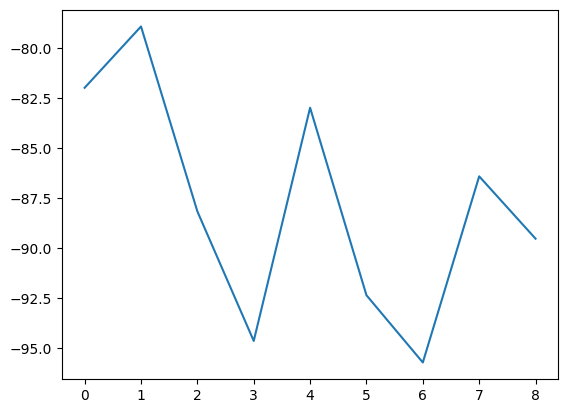

In [24]:
plt.plot(offsets)

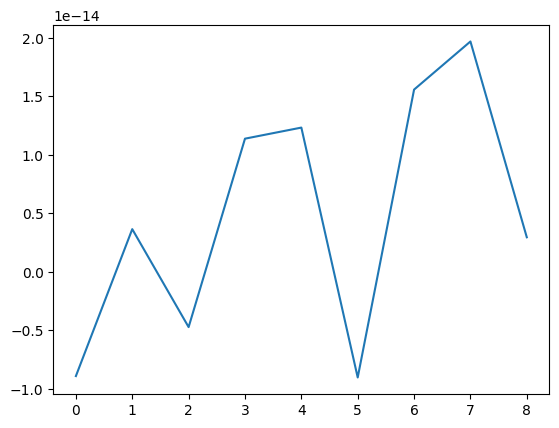

In [25]:
plt.plot(accuracies)